In [1]:
import pandas as pd
import numpy as np
from pandas import MultiIndex
import itertools
from operator import itemgetter
from geo_kpe_multidoc import GEO_KPE_MULTIDOC_CACHE_PATH
import re
import os
import joblib

from IPython.display import display
from matplotlib import pyplot as plt

from geo_kpe_multidoc.models.mdgeorank.mdgeorank import MdGeoRank, compute_weights_matrix, MoranI, GearyC, GetisOrdG
from geo_kpe_multidoc.geo.measures import cached_vincenty, inv_dist, exp_dist
from nltk.stem.porter import PorterStemmer

from geo_kpe_multidoc.datasets import load_dataset
from geo_kpe_multidoc.models.pre_processing.pre_processing_utils import (
    remove_new_lines_and_tabs,
    remove_whitespaces
)
from geo_kpe_multidoc.evaluation.evaluation_tools import (
    postprocess_model_outputs,
    evaluate_kp_extraction,
    evaluate_kp_extraction_base
)

from geo_kpe_multidoc.models.pre_processing.pre_processing_utils import (
    remove_hyphens_and_dots,
    stemming,
)

from functools import partial

import math
import geopandas as gpd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

/cfs/home/u021406/miniconda3/envs/nlp/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cfs/home/u021406/miniconda3/envs/nlp/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cfs/home/u021406/miniconda3/envs/nlp/lib/python3.10/site-packag

In [2]:
# Get Dataset and Labels
mkduc01 = load_dataset("MKDUC01-Trunk-20")

true_labels = dict()

for _, _, gold_kp in mkduc01:
    true_labels.setdefault("dataset", []).append(gold_kp)

2023-10-20 18:53:29.858 | INFO     | geo_kpe_multidoc.datasets.datasets:_read_mdkpe:133 - Load json with 30 topics


In [3]:
"""
    def __init__(
        self,
        experiment: str,
        stemmer: StemmerI,
        d_threshold=1000,
        weight_function: Callable = inv_dist,
        weight_function_param=500,
        **kwargs
    ) -> None:
"""

best_EmbedRank = "MKDUC01-MDKPERank-1788625193"
best_EmbedRank = "MKDUC01-Trunc20-MdEmbedRank-best"
best_PromptRank = "MKDUC01-MdPromptRank-1716932173"

experiment = best_EmbedRank
# experiment = best_PromptRank

ranker = MdGeoRank(experiment=experiment, stemmer=PorterStemmer(), weight_function = inv_dist, weight_function_param=0)
# ranker = MdGeoRank(experiment=experiment, stemmer=PorterStemmer(), weight_function = exp_dist, weight_function_param=1/(17000/10))

#results = ranker.geospacial_association()

## Functions

In [420]:

def performance(model_output, stemmer, show=False):
    model_results = model_output
    model_results = postprocess_model_outputs(
                    model_results, stemmer, None, [remove_new_lines_and_tabs, remove_whitespaces]
                )

    #performance_metrics = evaluate_kp_extraction_base(model_results, true_labels)
    performance_metrics = evaluate_kp_extraction(model_results, true_labels)
    # performance_metrics = pd.concat(
    #     [performance_metrics, evaluate_kp_extraction(model_results, true_labels)]
    # )
    if show:
        display(
            performance_metrics[["nDCG","F1_5", "F1_10", "F1_15"]].style.format('{:.2%}')
        )
    return performance_metrics.iloc[0]["F1_15"]


def plot_metrics(results, top_fp=100, normalize=True):
    metric_list = ['moran_i','geary_c', 'getisord_g']
    
    fig, ax = plt.subplots(nrows=1, ncols=len(metric_list), figsize=(16,5))
    fig.figure.set_size_inches 
    
    show_legend = True
    for g, idx in zip(ax, metric_list):
            not_gold_scores = (
                results[~results.in_gold]
                .reset_index()
                .sort_values(["topic", "semantic_score"], ascending=False)
                .groupby("topic")
                .head(top_fp)[idx]
            )
            not_gold_scores.plot.hist(density=normalize, alpha=0.8, ax=g)
            results[results.in_gold][idx].plot.hist(density=normalize, alpha=0.5, ax=g)
            #g.set_xlim((0, 1))
            if  idx == "getisord_g":
                idx = "Getis Ord G"
                g.legend(["False Positive", "True Keyphrase"])
                # temp_min = min(not_gold_scores.min(), results[results.in_gold][idx].min()))
                # temp_max = min(not_gold_scores.min(), results[results.in_gold][idx].min()))
                # xmin = min(not_gold_scores) if min(not_gold_scores) 0 else 0
                # xmax = min(not_gold_scores) if min(not_gold_scores) 0 else 0
            g.set(ylabel=None)
            g.set(yticks=[])
            g.set_title(idx.replace("_", " ").title(), fontsize=12)
            # if show_legend:
            #     g.legend(["False Positive", "True Keyphrase"])
            #     show_legend = False

    for x in ax:
        x.spines['top'].set_visible(False)
        x.spines['right'].set_visible(False)
        if normalize:
            x.spines['left'].set_visible(False)
    plt.show()


def plot_score(results, top_fp=100, normalize=True):
    idx = 'semantic_score'
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.4, 4.8))
    # fig.figure.set_size_inches
    
    show_legend = True
    not_gold_scores = (
        results[~results.in_gold]
        .reset_index()
        .sort_values(["topic", "semantic_score"], ascending=False)
        .groupby("topic")
        .head(top_fp)[idx]
    )
    not_gold_scores.plot.hist(density=normalize, alpha=0.8, ax=ax)
    results[results.in_gold][idx].plot.hist(density=normalize, alpha=0.5, ax=ax)
    ax.set(ylabel=None)
    ax.set(yticks=[])
    ax.set_title(idx.replace("_", " ").title(), fontsize=12)
    if show_legend:
        ax.legend(["False Positive", "True Keyphrase"])
        show_legend = False
    plt.show()

# Tests

In [502]:
Path(GEO_KPE_MULTIDOC_CACHE_PATH).joinpath(experiment)

PosixPath('/cfs/home/u021406/thesis/cache/MKDUC01-MDKPERank-1788625193')

In [33]:
from pathlib import Path

# [filename for filename in ranker._get_files(Path(GEO_KPE_MULTIDOC_CACHE_PATH).joinpath(experiment))]

p =  joblib.load(
                Path(GEO_KPE_MULTIDOC_CACHE_PATH).joinpath(experiment, "d24-mdkpe-results.pkl")
            )


In [27]:
topic_doc_coordinates = ranker._load_md_coordinates()
semantic_rank_model_outputs = ranker._load_semantic_rank_model_outputs()

In [43]:
base_model = "EmbedRank+pos"

def geospatial_association():

    results = pd.DataFrame()
    
    for topic_id, topic_model_outputs in tqdm(semantic_rank_model_outputs.items()):
    
        if base_model == "EmbedRank":
            documents_embeddings = topic_model_outputs["documents_embeddings"]
            candidates_embeddings = topic_model_outputs["candidate_embeddings"]
            candidate_scores_per_doc = pd.DataFrame(
                cosine_similarity(documents_embeddings, candidates_embeddings)
            )
            candidate_scores_per_doc.index = documents_embeddings.index
            candidate_scores_per_doc.columns = candidates_embeddings.index
        elif base_model == "EmbedRank+pos":
            documents_embeddings = topic_model_outputs["documents_embeddings"]
            candidates_embeddings = topic_model_outputs["candidate_embeddings"]
            
            candidate_scores_per_doc = pd.DataFrame(
                cosine_similarity(documents_embeddings, candidates_embeddings)
            )
            candidate_scores_per_doc.index = documents_embeddings.index
            candidate_scores_per_doc.columns = candidates_embeddings.index
    
            scores_per_doc = []
            for doc_id, doc_scores in topic_model_outputs["score_per_document"].items():
                for candidate, score in doc_scores[0]:
                    if np.isnan(score): 
                        score = (1 + 1.2e8 / (256**3)) * math.log(abs(candidate_scores_per_doc.loc[doc_id, candidate]))
                    scores_per_doc.append( {"doc": doc_id, "candidate": candidate, "score": score} )
            
            candidate_scores_per_doc = pd.DataFrame(
               scores_per_doc
            ).pivot(index="doc", columns="candidate", values="score")
        elif base_model == "PromptRank":
            candidate_scores_per_doc = pd.DataFrame(
                [
                    {"doc": doc_id, "candidate": candidate, "score": score}
                    for doc_id, doc_scores in topic_model_outputs[
                        "score_per_document"
                    ].items()
                    for candidate, score in doc_scores[0]
                ]
            ).pivot(index="doc", columns="candidate", values="score")
        else:
            raise ValueError("Invalid base model")
    
        candidate_scores = pd.DataFrame(
            topic_model_outputs["top_n_scores"],
            columns=["candidate", "semantic_score"],
        ).set_index("candidate")
    
        gold_stem = topic_model_outputs["gold_kp"]
    
        candidate_scores["in_gold"] = False
        for i, kp in enumerate(candidate_scores.index):
            if (
                stemming(remove_hyphens_and_dots(kp), stemmer=ranker.stemmer)
                in gold_stem
            ):
                candidate_scores.loc[kp, "in_gold"] = True
    
        candidate_scores["N"] = topic_model_outputs[
            "candidate_document_matrix"
        ].sum(axis=1)
        candidate_scores.index.name = "candidate"
    
        topic_point_scores = gpd.GeoDataFrame(
            candidate_scores_per_doc.join(topic_doc_coordinates.loc[topic_id])
        ).dropna().reset_index(drop=True)

        # when the same location apears in multiple documents, the semantic score
        # for that location is the mean of value for that location
        topic_point_scores = (
            topic_point_scores.groupby("_geometry").mean().reset_index()
        )
        topic_point_scores = gpd.GeoDataFrame(topic_point_scores, geometry="_geometry")
    
        #print(f"{topic_id}: topic_point_scores: {len(topic_point_scores)} observations.")
        topic_point_scores = topic_point_scores[
            ~topic_point_scores["_geometry"].is_empty
        ]
        
        weights = compute_weights_matrix(
            topic_point_scores["_geometry"],
            ranker.weight_function,
            ranker.weight_function_param,
        )

        # DEBUG
        #return weights, topic_point_scores
        
        topic_point_scores = topic_point_scores.drop("_geometry", axis=1)

        
        
        __moran_i = partial(MoranI, weight_matrix=weights)
        # only a few values maybe not usefull to move to GPU
        # __moran_i = partial(MoranI, weight_matrix=weights, device=self.device)
        __geary_c = partial(GearyC, weight_matrix=weights)
        __getisord_g = partial(GetisOrdG, weight_matrix=weights)
    
        geo_associations = pd.DataFrame()
        geo_associations["moran_i"] = topic_point_scores.agg(__moran_i)
        geo_associations["geary_c"] = topic_point_scores.agg(__geary_c)
        geo_associations["getisord_g"] = topic_point_scores.agg(__getisord_g)
        
        topic_scores = candidate_scores.join(geo_associations)
        # topic_scores["N"] = N
        # topic_scores.index.name = "candidate"
        topic_scores["topic"] = topic_id
        topic_scores.set_index(["topic", topic_scores.index])
        results = pd.concat([results, topic_scores])
    results = results.set_index(["topic", results.index])
    return results

In [37]:
weigths, topic_point_scores = geospatial_association()

  0%|                                                                                                                                                                                                                 | 0/30 [00:00<?, ?it/s]


In [40]:
coordinates = [(y, x) for x, y in zip(topic_point_scores["_geometry"].x, topic_point_scores["_geometry"].y)]
n = len(coordinates)

weight_matrix = np.zeros((n, n))
inds = np.triu_indices_from(weight_matrix, k=1)  # k=1 don't compute diagonal
for i, j in zip(*inds):
        weight_matrix[i, j] = (
            # To exploit caching the function parameter order must be the same.
            # Fortunatly, distance is simetric so we keep always the smallest value first,
            # by comparison on the sum (lat+long vs lat+long).
            cached_vincenty(coordinates[i], coordinates[j])
            if sum(coordinates[i]) <= sum(coordinates[j])
            else cached_vincenty(coordinates[i], coordinates[j])
        )
weight_matrix = weight_matrix + weight_matrix.T
weight_matrix[np.diag_indices_from(weight_matrix)] = np.nan
weight_matrix = exp_dist(weight_matrix, 1/(17000/10))
weight_matrix = np.nan_to_num(weight_matrix)

weight_matrix[:3, :3]


array([[0.        , 0.39051925, 0.50640511],
       [0.39051925, 0.        , 0.76143518],
       [0.50640511, 0.76143518, 0.        ]])

In [592]:
def compute_weights_matrix(
    points,
    weight_function,
    weight_function_param,
):
    # cord_list (lat, long)
    coordinates = [(y, x) for x, y in zip(points.x, points.y)]
    n = len(coordinates)

    weight_matrix = np.zeros((n, n))
    inds = np.triu_indices_from(weight_matrix, k=1)  # k=1 don't compute diagonal
    for i, j in zip(*inds):
        weight_matrix[i, j] = (
            # To exploit caching the function parameter order must be the same.
            # Fortunatly, distance is simetric so we keep always the smallest value first,
            # by comparison on the sum (lat+long vs lat+long).
            cached_vincenty(coordinates[i], coordinates[j])
            if sum(coordinates[i]) <= sum(coordinates[j])
            else cached_vincenty(coordinates[i], coordinates[j])
        )
    weight_matrix = weight_matrix + weight_matrix.T  # - np.diag(0, n)

    weight_matrix = weight_function(weight_matrix, weight_function_param)

    # row standartize
    weight_matrix = weight_matrix / weight_matrix.sum(axis=1)

    return weight_matrix

## Do test

In [ ]:
base_model = "PromptRank"
results = geospatial_association()
plot_metrics(results)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:06<00:00,  2.20s/it]


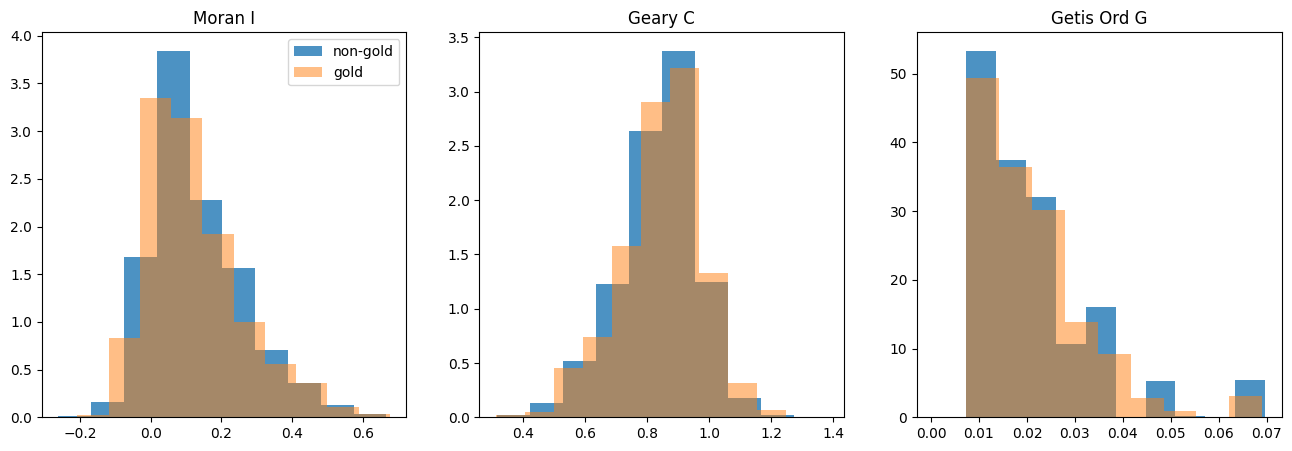

In [67]:
base_model = "EmbedRank+pos"
results = geospatial_association()
plot_metrics(results)

# Spacial Association Plots

In [ ]:
for func_, func_param in zip(
            # [inv_dist, inv_dist, inv_dist, inv_dist, exp_dist, exp_dist, exp_dist, exp_dist],
            [exp_dist, exp_dist, exp_dist, exp_dist, exp_dist],
            [1/2, 1/3, 1/5, 1/10, 1/100]):
    ranker.weight_function = func_
    ranker.weight_function_param = func_param

    results = geospatial_association()

    display(func_, func_param)
    plot_metrics(results)

In [ ]:
for func_, func_param in zip(
            # [inv_dist, inv_dist, inv_dist, inv_dist, exp_dist, exp_dist, exp_dist, exp_dist],
            [inv_dist, inv_dist, inv_dist, inv_dist],
            [1, 100, 500, 1000]):
    ranker.weight_function = func_
    ranker.weight_function_param = func_param

    results = geospatial_association()

    display(func_, func_param)
    plot_metrics(results)

In [425]:
results[results.in_gold]

semantic_score  in_gold  N  moran_i   
topic candidate                                                            
d54   congressional term limitation       -1.382233     True  1      1.0  \
      political institutions              -1.563326     True  1      1.0   
      constitutional changes              -1.571546     True  1      1.0   
      state legislators                   -1.648888     True  3      1.0   
      congressional officeholders         -1.654556     True  1      1.0   
...                                             ...      ... ..      ...   
d24   medical practice                    -4.299879     True  1      1.0   
      addictions                          -4.381224     True  1      1.0   
      rehabilitation clinic               -4.576060     True  1      1.0   
      ms. taylor                          -4.842547     True  1      1.0   
      investigation                       -5.564916     True  1      1.0   

                                          geary_c  getisord_g  
topic candidate                                                
d54   congressional term limitation  2.017234e-08    0.034500  
      political institutions         1.717657e-08    0.034487  
      constitutional changes         5.223241e-09    0.034495  
      state legislators              2.038670e-09    0.034489  
      congressional officeholders    2.862560e-09    0.034494  
...                                           ...         ...  
d24   medical practice               1.391434e-16    0.066677  
      addictions                     2.509951e-16    0.066675  
      rehabilitation clinic          2.195150e-15    0.066683  
      ms. taylor                     1.618220e-15    0.066683  
      investigation                  9.255902e-16    0.066686  

[1406 rows x 6 columns]

# Test Rank with code base

### Local Geospatial Association Function

In [35]:
def local_geospatial_association(topic_doc_coordinates, semantic_rank_model_outputs, weight_function, weight_function_param, stemmer):
    results = pd.DataFrame()
    for topic_id, topic_model_outputs in semantic_rank_model_outputs.items():
        candidate_scores_per_doc = pd.DataFrame(
            [
                {"doc": doc_id, "candidate": candidate, "score": score}
                for doc_id, doc_scores in topic_model_outputs[
                    "score_per_document"
                ].items()
                for candidate, score in doc_scores[0]
            ]
        ).pivot(index="doc", columns="candidate", values="score")

        candidate_scores = pd.DataFrame(
            topic_model_outputs["top_n_scores"],
            columns=["candidate", "semantic_score"],
        ).set_index("candidate")

        gold_stem = topic_model_outputs["gold_kp"]

        candidate_scores["in_gold"] = False
        for i, kp in enumerate(candidate_scores.index):
            if (
                stemming(remove_hyphens_and_dots(kp), stemmer=stemmer)
                in gold_stem
            ):
                candidate_scores.loc[kp, "in_gold"] = True

        candidate_scores["N"] = topic_model_outputs[
            "candidate_document_matrix"
        ].sum(axis=1)
        candidate_scores.index.name = "candidate"

        topic_point_scores = (
            gpd.GeoDataFrame(
                candidate_scores_per_doc.join(topic_doc_coordinates.loc[topic_id])
            )
            .dropna()  # dropna for documents without any location
            .reset_index(drop=True)
        )
        # when the same location apears in multiple documents, the semantic score
        # for that location is the mean of values for that location
        topic_point_scores = (
            topic_point_scores.groupby("_geometry").mean().reset_index()
        )
        topic_point_scores = gpd.GeoDataFrame(
            topic_point_scores, geometry="_geometry"
        )

        # print(f"{topic_id}: topic_point_scores: {len(topic_point_scores)}
        # observations.")
        topic_point_scores = topic_point_scores[
            ~topic_point_scores["_geometry"].is_empty
        ]
        # print(f"{topic_id}: topic_point_scores: {len(topic_point_scores)} without
        # empty observations")

        weights = compute_weights_matrix(
            topic_point_scores["_geometry"],
            weight_function,
            weight_function_param,
        )

        topic_point_scores = topic_point_scores.drop("_geometry", axis=1)

        __moran_i = partial(MoranI, weight_matrix=weights)
        # only a few values maybe not usefull to move to GPU
        # __moran_i = partial(MoranI, weight_matrix=weights, device=self.device)
        __geary_c = partial(GearyC, weight_matrix=weights)
        __getisord_g = partial(GetisOrdG, weight_matrix=weights)

        geo_associations = pd.DataFrame()
        geo_associations["moran_i"] = topic_point_scores.agg(__moran_i)
        geo_associations["geary_c"] = topic_point_scores.agg(__geary_c)
        geo_associations["getisord_g"] = topic_point_scores.agg(__getisord_g)

        topic_scores = candidate_scores.join(geo_associations)
        # topic_scores["N"] = N
        # topic_scores.index.name = "candidate"
        topic_scores["topic"] = topic_id
        topic_scores.set_index(["topic", topic_scores.index])
        results = pd.concat([results, topic_scores])

    geo_association_results = results.set_index(["topic", results.index])
    return geo_association_results
    

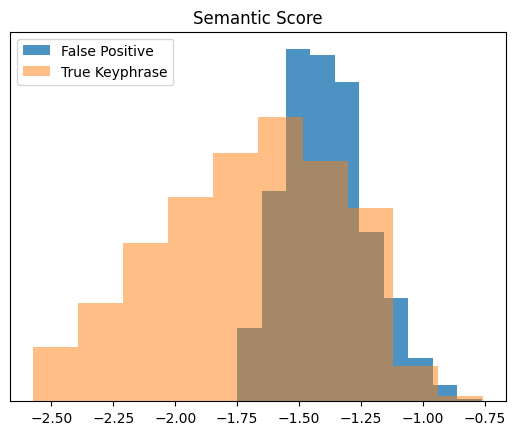

In [86]:
def plot_score(results, top_fp=100, normalize=True):
    idx = 'semantic_score'
    
    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.4, 4.8))
    fig, ax = plt.subplots()
    fig.figure.set_size_inches
    
    show_legend = True
    not_gold_scores = (
        results[~results.in_gold]
        .reset_index()
        .sort_values(["topic", "semantic_score"], ascending=False)
        .groupby("topic")
        .head(top_fp)[idx]
    )
    not_gold_scores.plot.hist(density=normalize, alpha=0.8, ax=ax)
    results[results.in_gold][idx].plot.hist(density=normalize, alpha=0.5, ax=ax)
    ax.set(ylabel=None)
    ax.set(yticks=[])
    ax.set_title(idx.replace("_", " ").title(), fontsize=12)
    if show_legend:
        ax.legend(["False Positive", "True Keyphrase"])
        show_legend = False
    plt.show()

plot_score(results, 20, normalize=False)

### Compute Geo Associations -> results

In [430]:

# results = ranker.geospacial_association()
results = local_geospatial_association(topic_doc_coordinates, semantic_rank_model_outputs, 
                                       #weight_function = inv_dist, weight_function_param=0,
                                       weight_function = exp_dist, weight_function_param=1/1700,
                                       stemmer=PorterStemmer())

### Plot Geospatial Association Top 20, 40 False Positives

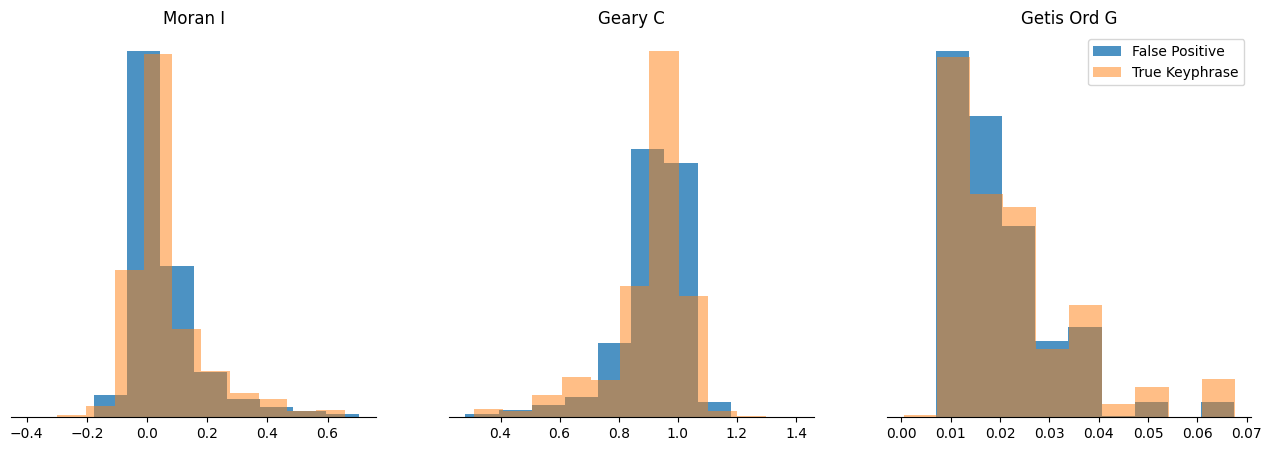

In [431]:
# inv_dist
plot_metrics(results, 10000, normalize=True)

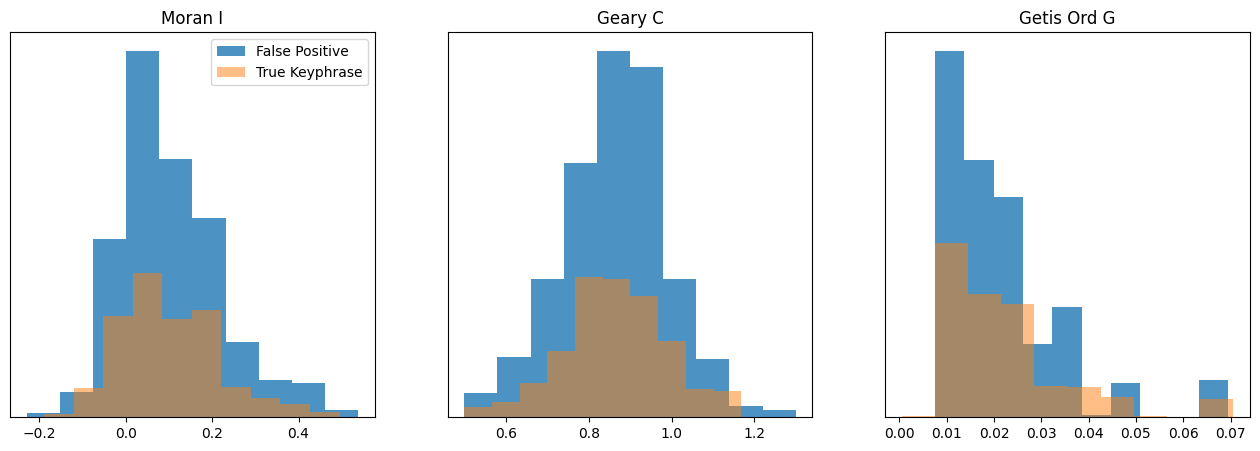

In [89]:
# exp_dist
plot_metrics(results, 40, normalize=False)

### Plot Semantic Score Distribution

### Correlation Table

In [362]:
# inv dist
# results = r_inv_dist

top_fp = 1000

not_gold_scores = (
                results[~results.in_gold]
                .reset_index()
                .sort_values(["topic", "semantic_score"], ascending=False)
                .groupby("topic")
                .head(top_fp)
            )
in_gold_scores = results[results.in_gold]

r =  pd.concat([not_gold_scores, in_gold_scores]).rename(
        columns={
            "in_gold": "True Keyphrase",
            "semantic_score": "Semantic score",
            "moran_i": "Moran I",
            "geary_c": "Geary C",
            "getisord_g": "Getis Ord G",
            "N": "N docs"
            # "_base_Recall": "Recall",
        }
    )

corr = (r
        .loc[ : , ['True Keyphrase', "Semantic score", "Moran I", "Geary C", "Getis Ord G" ,"N docs", ]].corr()
       )
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.tril_indices_from(mask)] = True
corr[mask] = np.nan
#(corr.iloc[:1, 1:]
#print(

display(corr.iloc[:-1, 1:] 
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))
 #.to_latex(convert_css=True)
#)

print(
(corr.iloc[:-1, 1:] 
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))
 .to_latex(convert_css=True)
)



,Semantic score,Moran I,Geary C,Getis Ord G,N docs
True Keyphrase,0.18,0.00,-0.00,0.02,0.11
Semantic score,nan,-0.09,0.09,0.15,0.13
Moran I,nan,nan,-0.94,-0.09,0.01
Geary C,nan,nan,nan,0.02,0.01
Getis Ord G,nan,nan,nan,nan,0.02


\begin{tabular}{lrrrrr}
 & Semantic score & Moran I & Geary C & Getis Ord G & N docs \\
True Keyphrase & {\cellcolor[HTML]{F0CDBB}} \color[HTML]{000000} 0.18 & {\cellcolor[HTML]{DDDCDC}} \color[HTML]{000000} 0.00 & {\cellcolor[HTML]{DCDDDD}} \color[HTML]{000000} -0.00 & {\cellcolor[HTML]{DFDBD9}} \color[HTML]{000000} 0.02 & {\cellcolor[HTML]{EAD4C8}} \color[HTML]{000000} 0.11 \\
Semantic score & {\cellcolor[HTML]{000000}} \color[HTML]{F1F1F1} {\cellcolor[HTML]{F1F1F1}} nan & {\cellcolor[HTML]{D1DAE9}} \color[HTML]{000000} -0.09 & {\cellcolor[HTML]{E8D6CC}} \color[HTML]{000000} 0.09 & {\cellcolor[HTML]{EED0C0}} \color[HTML]{000000} 0.15 & {\cellcolor[HTML]{ECD3C5}} \color[HTML]{000000} 0.13 \\
Moran I & {\cellcolor[HTML]{000000}} \color[HTML]{F1F1F1} {\cellcolor[HTML]{F1F1F1}} nan & {\cellcolor[HTML]{000000}} \color[HTML]{F1F1F1} {\cellcolor[HTML]{F1F1F1}} nan & {\cellcolor[HTML]{4358CB}} \color[HTML]{F1F1F1} -0.94 & {\cellcolor[HTML]{D2DBE8}} \color[HTML]{000000} -0.09 & {\cellcolor[HT

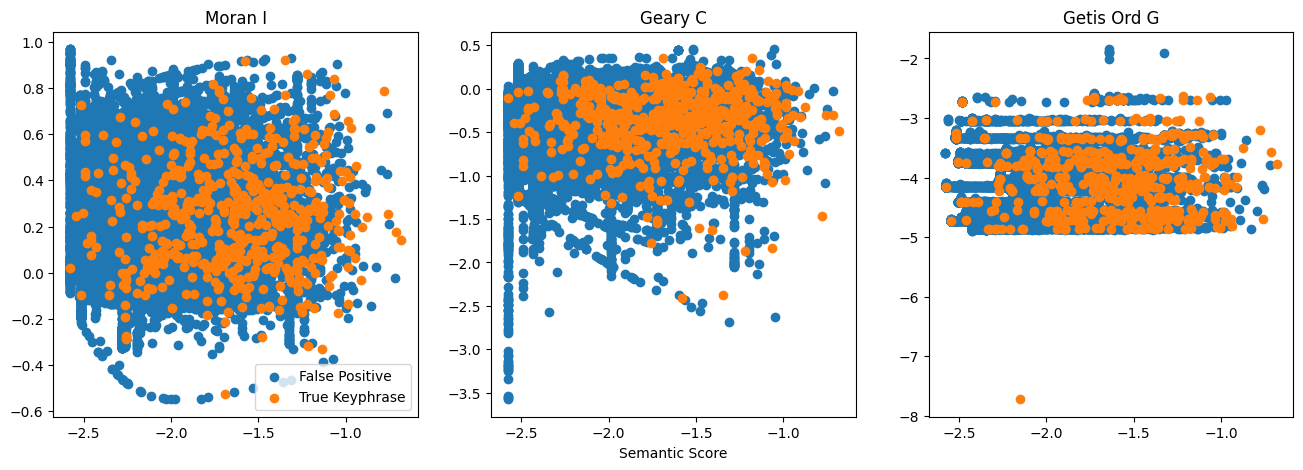

In [388]:
# not_gold_scores['semantic_score'].plot.hist()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
fig.figure.set_size_inches 

ax[0].scatter(not_gold_scores['semantic_score'] + 0.12 * np.log(not_gold_scores['N']), not_gold_scores['moran_i'])
ax[0].scatter(in_gold_scores['semantic_score'] + 0.12 * np.log(in_gold_scores['N']), in_gold_scores['moran_i'])
#ax[0].set_xlabel("Semantic Score")
ax[0].legend(["False Positive", "True Keyphrase"])
ax[0].set_title("Moran I")

ax[1].scatter(not_gold_scores['semantic_score'] + 0.12 * np.log(not_gold_scores['N']), np.log(not_gold_scores['geary_c']))
ax[1].scatter(in_gold_scores['semantic_score']+ 0.12 * np.log(in_gold_scores['N']), np.log(in_gold_scores['geary_c']))
ax[1].set_xlabel("Semantic Score")
ax[1].set_title("Geary C")

ax[2].scatter(not_gold_scores['semantic_score'] + 0.12 * np.log(not_gold_scores['N']), np.log(not_gold_scores['getisord_g']))
ax[2].scatter(in_gold_scores['semantic_score'] + 0.12 * np.log(in_gold_scores['N']), np.log(in_gold_scores['getisord_g']))
# ax[2].set_xlabel("Semantic Score")
ax[2].set_title("Getis Ord G")
plt.show()

#in_gold_scores['semantic_score'].plot.hist()

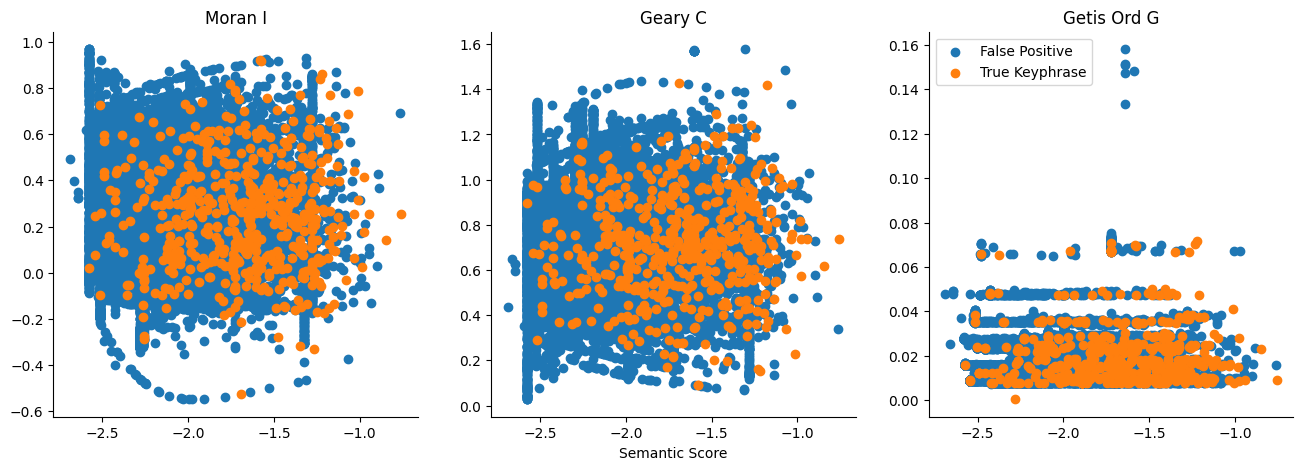

In [417]:
# not_gold_scores['semantic_score'].plot.hist()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
fig.figure.set_size_inches 

ax[0].scatter(not_gold_scores['semantic_score'], not_gold_scores['moran_i'])
ax[0].scatter(in_gold_scores['semantic_score'], in_gold_scores['moran_i'])
#ax[0].set_xlabel("Semantic Score")
ax[0].set_title("Moran I")
# ax.spines['left'].set_visible(False)

ax[1].scatter(not_gold_scores['semantic_score'] , not_gold_scores['geary_c'])
ax[1].scatter(in_gold_scores['semantic_score'] , in_gold_scores['geary_c'])
ax[1].set_xlabel("Semantic Score")
ax[1].set_title("Geary C")

ax[2].scatter(not_gold_scores['semantic_score'] , not_gold_scores['getisord_g'])
ax[2].scatter(in_gold_scores['semantic_score'] , in_gold_scores['getisord_g'])
# ax[2].set_xlabel("Semantic Score")
ax[2].set_title("Getis Ord G")

ax[2].legend(["False Positive", "True Keyphrase"])
for x in ax:
    x.spines['top'].set_visible(False)
    x.spines['right'].set_visible(False)

plt.show()

#in_gold_scores['semantic_score'].plot.hist()

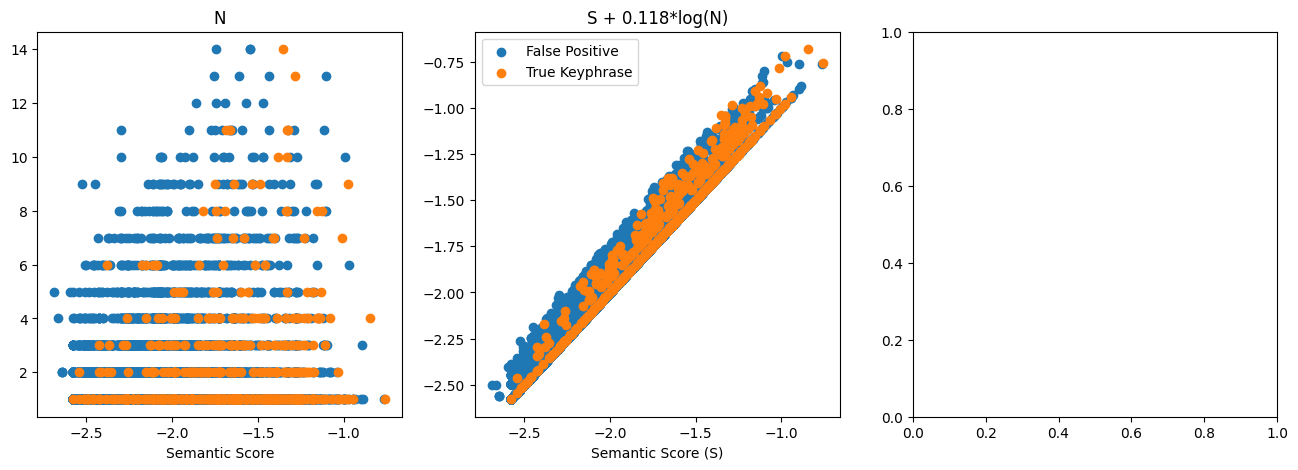

In [378]:
# not_gold_scores['semantic_score'].plot.hist()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
fig.figure.set_size_inches 

ax[1].scatter(not_gold_scores['semantic_score'], not_gold_scores['semantic_score'] + 0.118 * np.log(not_gold_scores['N']))
ax[1].scatter(in_gold_scores['semantic_score'], in_gold_scores['semantic_score'] + 0.118 * np.log(in_gold_scores['N']))
ax[1].set_xlabel("Semantic Score (S)")
ax[1].legend(["False Positive", "True Keyphrase"])
ax[1].set_title("S + 0.118*log(N)")

ax[0].scatter(not_gold_scores['semantic_score'], not_gold_scores['N'])
ax[0].scatter(in_gold_scores['semantic_score'], in_gold_scores['N'])
ax[0].set_xlabel("Semantic Score")
#ax[0].legend(["False Positive", "True Keyphrase"])
ax[0].set_title("N")

# ax[2].scatter(not_gold_scores['semantic_score'], not_gold_scores['getisord_g'])
# ax[2].scatter(in_gold_scores['semantic_score'], in_gold_scores['getisord_g'])
# # ax[2].set_xlabel("Semantic Score")
# ax[2].set_title("Getis Ord G")
plt.show()

#in_gold_scores['semantic_score

In [171]:
results.to_parquet("results_embedrank_a1.parquet")
# results = pd.read_parquet("results.parquet")
# results = pd.read_parquet("results1.parquet")

In [104]:
(results.reset_index()
            .sort_values(["topic", "semantic_score"], ascending=False)
            .groupby("topic")
            .head(10)
            .pipe(lambda x: x.loc[x.topic == "d59"])
)

,topic,candidate,semantic_score,in_gold,N,moran_i,geary_c,getisord_g
20726,d59,events,-991.013996,False,1,0.102885,0.822145,0.054082
20803,d59,flight,-993.046698,False,4,0.103475,0.821608,0.058031
21279,d59,pan american world airways flight,-997.584106,False,1,0.103254,0.821828,0.051507
21449,d59,scotland,-1051.659408,False,1,0.103391,0.821699,0.058078
21196,d59,news,-1107.202275,False,2,0.103439,0.821654,0.057433
20652,d59,developments today,-1194.302158,False,1,0.103398,0.821689,0.055944
21135,d59,mishaps,-1265.984459,False,1,0.103198,0.821861,0.056934
20952,d59,incidents,-1280.383018,False,1,0.103363,0.821721,0.058396
20344,d59,accidents,-1281.546648,False,1,0.103061,0.821993,0.056861
21437,d59,safety issues,-1317.638443,False,1,0.103412,0.821678,0.059195


In [13]:
# corr = (r
#         .loc[ : , ['topic', "semantic_score", "moran_i", "geary_c", "getisord_g" ,"N", ]].corr()
#        )

from scipy.stats import boxcox
r = results.copy()

# "semantic_score", 
#for col in ["moran_i", "geary_c", "getisord_g", "N"]:
#    r[col], _ = boxcox(r[col])

r['semantic_score'] = np.exp(r['semantic_score'])

corr = (r
        .loc[ : , ['in_gold', "semantic_score", "moran_i", "geary_c", "getisord_g" ,"N", ]].corr()
       )
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.tril_indices_from(mask)] = True
corr[mask] = np.nan
#(corr.iloc[:1, 1:]
#print(
(corr 
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))
 #.to_latex(convert_css=True)
#)

,in_gold,semantic_score,moran_i,geary_c,getisord_g,N
in_gold,nan,0.20,0.00,-0.00,0.03,0.10
semantic_score,nan,nan,-0.01,0.02,0.14,0.11
moran_i,nan,nan,nan,-0.84,-0.11,-0.00
geary_c,nan,nan,nan,nan,0.17,0.02
getisord_g,nan,nan,nan,nan,nan,0.02
N,nan,nan,nan,nan,nan,nan


In [335]:
print(round((22.35/21.91-1)*100, ndigits=1), "%")
print(round((25.45/24.51-1)*100, ndigits=1), "%")

2.0 %
3.8 %


In [416]:
#       54.18  14.51   21.91  24.51
#                                          	nDCG 	F1_5 	F1_10 	F1_15
# alpha = 0.86 , softmax                     53.97% 	12.90% 	20.79% 	25.27%
# alpha = 0.86 , N / 14  -                   53.82% 	12.60% 	21.22% 	25.26%  
# alpha = 0.11 log(N)                        55.48% 	14.51% 	22.35% 	25.45%
# alpha = 0.118 log(N)                       55.69% 	14.78% 	22.35% 	25.45%
# alpha = 0.13  log(N)                       55.19% 	14.51% 	21.89% 	25.64%
#                      Geary C

for alpha in list(np.linspace(0.5, 1.5, 10)):
    print(f"alpha = {alpha}")
    performance(local_rank(results, alpha, None,  None),  PorterStemmer(), True)  
# performance(local_rank(results, 0.1, None,  None),  PorterStemmer(), True)
# 55.69% 	14.78% 	22.35% 	25.45%
# 55.69% 	15.05% 	22.35% 	25.45%

alpha = 0.5


,nDCG,F1_5,F1_10,F1_15
dataset,53.88%,13.45%,20.35%,24.31%


alpha = 0.6111111111111112


,nDCG,F1_5,F1_10,F1_15
dataset,53.45%,13.44%,20.13%,24.69%


alpha = 0.7222222222222222


,nDCG,F1_5,F1_10,F1_15
dataset,53.54%,13.17%,21.24%,24.69%


alpha = 0.8333333333333333


,nDCG,F1_5,F1_10,F1_15
dataset,53.71%,13.17%,21.68%,24.11%


alpha = 0.9444444444444444


,nDCG,F1_5,F1_10,F1_15
dataset,53.70%,13.17%,21.01%,23.35%


alpha = 1.0555555555555556


,nDCG,F1_5,F1_10,F1_15
dataset,53.48%,12.64%,20.56%,23.73%


alpha = 1.1666666666666665


,nDCG,F1_5,F1_10,F1_15
dataset,53.31%,12.90%,20.33%,23.73%


alpha = 1.2777777777777777


,nDCG,F1_5,F1_10,F1_15
dataset,53.17%,12.64%,20.33%,23.54%


alpha = 1.3888888888888888


,nDCG,F1_5,F1_10,F1_15
dataset,52.92%,12.09%,20.11%,22.97%


alpha = 1.5


,nDCG,F1_5,F1_10,F1_15
dataset,52.60%,11.83%,19.67%,22.58%


### Final Score Function

In [415]:
# from scipy.special import softmax

def local_rank(geo_association_results, alpha, beta, gamma):
        final_score = pd.DataFrame().reindex_like(geo_association_results)

        #
        if alpha is not None:
            # final_score["score"] = geo_association_results["semantic_score"] * np.log((1 - geo_association_results["moran_i"]) ** alpha)
            # score for N
            
            # final_score["N_2"] = geo_association_results.groupby('topic')['N'].transform(softmax)
                   #final_score["N_2"] = geo_association_results['N'].transform(softmax)
            # final_score["score"] = geo_association_results["semantic_score"] + alpha*final_score["N_2"]
            # final_score["score"] = geo_association_results["semantic_score"] + alpha*geo_association_results["N"].transform(math.log)
            
            # final_score["score"] = geo_association_results["semantic_score"] + alpha*geo_association_results["geary_c"].transform(math.log)
            final_score["score"] = geo_association_results["semantic_score"] + alpha*geo_association_results["moran_i"] #+ 0.118*np.log(geo_association_results["N"])
            # final_score["score"] = geo_association_results["semantic_score"] + alpha*np.log(np.abs(geo_association_results["geary_c"]  - 0.7)) # + 0.1188*geo_association_results["N"].transform(math.log)
            # final_score["score"] = geo_association_results["semantic_score"] + geo_association_results["moran_i"] * alpha
        else:
            final_score["score"] = geo_association_results["semantic_score"]

        # final_score["N_2"].plot.hist()
        # final_score["score"].plot.hist()
        
        # final_score["score"] = geo_association_results["semantic_score"] - np.log(geo_association_results["geary_c"] ** (alpha))
        # final_score["score"] = geo_association_results["semantic_score"] - np.log(geo_association_results["geary_c"] ** (alpha))
        # final_score["score"] = 0.33*geo_association_results['semantic_score'] - 0.02*geo_association_results["moran_i"] + 0.07*geo_association_results["N"]
        # final_score["score"] = alpha*np.exp(geo_association_results['semantic_score']) + beta*geo_association_results["moran_i"] + gamma*geo_association_results["N"]/14
        rankings = {}
        for dataset in ["dataset"]:
            for topic in sorted(final_score.index.get_level_values(0).unique()):
                top_n_scores = sorted(
                    list(final_score.loc[topic]["score"].items()),
                    key=itemgetter(1),
                    reverse=True,
                )
                candidates = final_score.loc[topic].index.to_list()
                rankings.setdefault(dataset, []).append((top_n_scores, candidates))

        return rankings


In [141]:
performance(local_rank(results, None, None,  None), True)

KeyError: 'N_2'

In [65]:
performance(local_rank(r, 2, None,  None), True)

,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,59.77%,6.81%,11.18%,14.99%


0.14988274512307395

In [394]:
performance(local_rank(results, 51.46738654, 1029.18641968,   96.89047523), True)

,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,49.82%,3.49%,6.09%,7.12%


0.07123055587712232

In [365]:
performance(local_rank(results, 1, 0, 0), True)
performance(local_rank(results, 1, 0, 1), True)
performance(local_rank(results, 0, 1, 1), True)
performance(local_rank(results, 0, 0, 1), True)

,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.55%,8.87%,14.73%,19.98%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,56.53%,4.02%,6.27%,9.08%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,47.44%,2.85%,4.27%,5.72%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,51.96%,3.09%,4.42%,6.50%


0.06502312911981378

# Optimize

In [392]:
Xg = (results
     .copy()
     .assign(semantic_score = lambda df: np.exp(df.semantic_score))
     .assign(N= lambda df: df.N/df.N.max())
     .loc[results.in_gold, ["semantic_score", "moran_i", 'N']]
    )

Xng = (results
     .copy()
     .assign(semantic_score = lambda df: np.exp(df.semantic_score))
     .assign(N= lambda df: df.N/df.N.max())
     .loc[~results.in_gold, ["semantic_score", "moran_i", 'N']]
    )

In [388]:
X.shape

(1406, 3)

In [400]:
from scipy.optimize import minimize

initial_B = np.random.rand(X.shape[-1])  # Replace with your initial guess for B

# Define the objective function to maximize the L2 norm of X·B
def objective_function(B):
    return - (np.linalg.norm(np.dot(Xng, B), 2)  -  np.linalg.norm(np.dot(Xg, B), 2))  # Negative since we want to maximize

# Define any constraints on B, if necessary
# For example, you can set bounds on the elements of B:
# constraints = ({'type': 'ineq', 'fun': lambda B: B - lower_bound},
#                {'type': 'ineq', 'fun': lambda B: upper_bound - B})

# Solve the optimization problem
# result = minimize(objective_function, initial_B, constraints=constraints, method='SLSQP')
result = minimize(objective_function, initial_B)

# The optimal solution B is in result.x
optimal_B = result.x
optimal_B

array([  54.73448105, 1027.92774501,  103.55355852])

In [404]:
Xng.shape, Xg.shape

((33127, 3), (1406, 3))

In [ ]:
performance(local_rank(results, 51.46738654, 1029.18641968,   96.89047523), True)

-0.2105263157894739

19.950000000000003

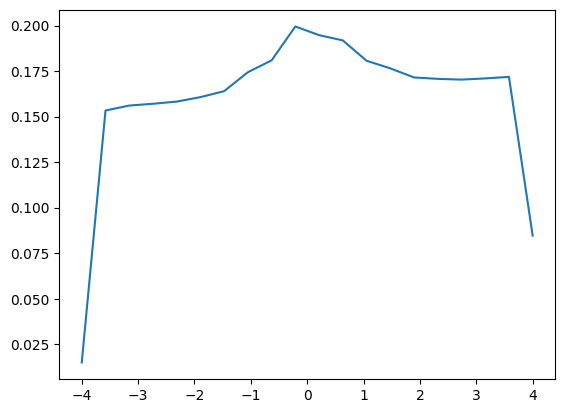

In [57]:
import numpy as np
from tqdm import tqdm 
alphas = list(np.linspace(-4, 4, 20))

f1_15 = []

for alpha in alphas:
    # print(f"alpha = {alpha}")
    f1_15_measure = performance(local_rank(r, alpha, 0, 0))
    f1_15.append(f1_15_measure)

display(alphas[f1_15.index(max(f1_15))], round(max(f1_15), 4)*100)
plt.plot(alphas, f1_15)
plt.show()

0.02631578947368418

20.119999999999997

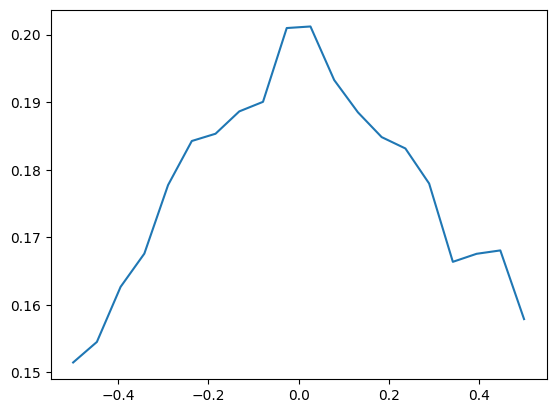

In [336]:
# Geary C

import numpy as np
from tqdm import tqdm 
alphas = list(np.linspace(-0.5, 0.5, 20))

f1_15 = []

for alpha in alphas:
    # print(f"alpha = {alpha}")
    f1_15_measure = performance(local_rank(results, alpha, 0, 0))
    f1_15.append(f1_15_measure)

display(alphas[f1_15.index(max(f1_15))], round(max(f1_15), 4)*100)
plt.plot(alphas, f1_15)
plt.show()

In [294]:
class GridIterator:
    def __init__(self):
        self.grid_size = 10
        self.current_x = 0
        self.current_y = 0
        self.current_z = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_x == self.grid_size:
            raise StopIteration

        triplet = (
            self.current_x / self.grid_size,
            self.current_y / self.grid_size,
            self.current_z / self.grid_size
        )

        self.current_z += 1
        if self.current_z == self.grid_size:
            self.current_z = 0
            self.current_y += 1
            if self.current_y == self.grid_size:
                self.current_y = 0
                self.current_x += 1

        if sum(triplet) == 1:
            return triplet
        else:
            return self.__next__()

# # Usage
# grid_iterator = GridIterator()
# for triplet in grid_iterator:
#     print(triplet)

In [348]:
grid_iterator = GridIterator()
f1_15 = []
points = []
for alpha, beta, gamma in GridIterator():
    display((alpha, beta, gamma))
    f1_15_measure = performance(local_rank(r, alpha, beta, gamma), True)
    f1_15.append(f1_15_measure)
    points.append((alpha, beta, gamma))

plt.plot(points, f1_15)
plt.show()

display(points[f1_15.index(max(f1_15))], round(max(f1_15), 4)*100)

(0.0, 0.1, 0.9)

,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.55%,8.87%,14.73%,19.98%


(0.0, 0.2, 0.8)

,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.55%,8.87%,14.73%,19.98%


(0.0, 0.3, 0.7)

,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.55%,8.87%,14.73%,19.98%


(0.0, 0.4, 0.6)

,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.55%,8.87%,14.73%,19.98%


(0.0, 0.5, 0.5)

KeyboardInterrupt: 

In [299]:
points[f1_15.index(max(f1_15))], round(max(f1_15), 4)*100

((0.6, 0.1, 0.3), 20.27)

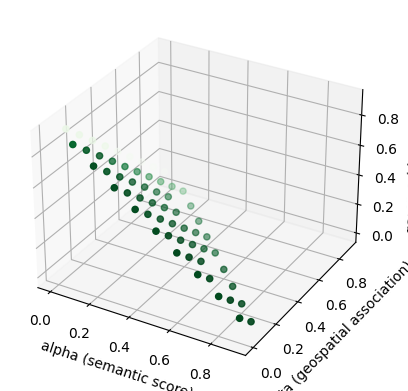

In [306]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = list(zip(*points))

# Plot the data points in 3D
ax.scatter(x, y, z, c=f1_15, cmap='Greens')

# Set labels for the axes
ax.set_xlabel('alpha (semantic score)')
ax.set_ylabel('beta (geospatial association)')
ax.set_zlabel('gamma (documents)')

# Show the plot
plt.show()

,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.47%,9.82%,15.45%,19.73%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.46%,9.82%,15.25%,19.62%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.53%,9.98%,15.25%,19.99%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.55%,10.21%,15.32%,20.09%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.58%,10.09%,15.31%,20.18%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.64%,10.19%,15.31%,20.05%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.64%,10.03%,15.21%,19.89%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.63%,10.03%,15.28%,19.89%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.64%,10.06%,15.28%,19.89%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.60%,9.93%,15.35%,19.96%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.64%,9.93%,15.35%,20.03%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.63%,9.93%,15.35%,19.91%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.67%,9.93%,15.28%,20.27%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.69%,9.93%,15.33%,20.21%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.58%,9.68%,15.21%,20.52%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.60%,9.68%,15.14%,20.34%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.60%,9.68%,14.97%,20.08%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.60%,9.68%,14.97%,20.09%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.59%,9.68%,14.85%,20.02%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.58%,9.44%,14.85%,20.01%


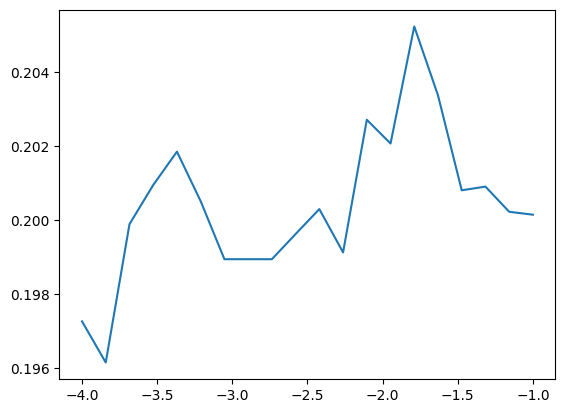

In [169]:
import numpy as np
from tqdm import tqdm 
alphas = list(np.linspace(-4, -1, 20))

f1_15 = []

for alpha in alphas:
    # print(f"alpha = {alpha}")
    f1_15_measure = performance(ranker.rank(results, alpha=alpha))
    f1_15.append(f1_15_measure)

plt.plot(alphas, f1_15)
plt.show()

,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.56%,9.33%,15.07%,19.67%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.59%,9.40%,15.07%,19.67%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.58%,9.40%,15.00%,19.83%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.58%,9.40%,14.92%,19.83%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.48%,9.33%,14.92%,19.90%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.49%,9.10%,14.86%,19.96%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.61%,9.10%,14.77%,19.96%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.63%,9.10%,14.74%,19.96%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.64%,9.10%,14.74%,19.89%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.62%,8.94%,14.74%,19.84%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.62%,9.02%,14.83%,19.91%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.63%,9.02%,14.83%,19.98%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.63%,9.02%,14.91%,20.05%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.64%,9.02%,14.91%,20.21%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.66%,9.02%,14.79%,20.14%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.66%,8.88%,14.79%,20.13%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.66%,8.88%,14.67%,20.13%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.51%,8.88%,14.81%,20.13%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.55%,8.95%,14.73%,20.13%


,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.55%,8.87%,14.73%,19.98%


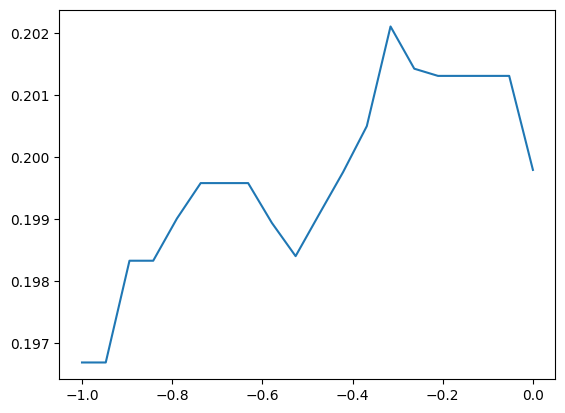

In [310]:
import numpy as np
from tqdm import tqdm 
alphas = list(np.linspace(-1, 0, 20))

f1_15 = []

for alpha in alphas:
    # print(f"alpha = {alpha}")
    f1_15_measure = performance(ranker.rank(results, alpha=alpha))
    f1_15.append(f1_15_measure)

plt.plot(alphas, f1_15)
plt.show()

In [411]:
performance(ranker.rank(results, alpha=-1.8), True)
display(vars(ranker))

,Recall,nDCG,F1_5,F1_10,F1_15
dataset_base_eval,90.33%,65.59%,9.78%,15.21%,20.52%


{'experiment': 'MKDUC01-MDKPERank-1788625193',
 'd_threshold': 100000,
 'weight_function': <function geo_kpe_multidoc.geo.measures.inv_dist(d: numpy.ndarray, a=1)>,
 'weight_function_param': 1,
 'stemmer': <PorterStemmer>,
 'device': device(type='cpu'),
 '_geo_association_index': <GeospacialAssociationIndex.MORAN_I: 'moran_i'>}

In [ ]:

# performance(ranker.rank(results, alpha=-1.8), True)
display(vars(ranker))

In [14]:
# results[~results.in_gold].moran_i.plot.hist(alpha=0.8)

#metric_list = ['semantic_score', 'moran_i'] #, 'moran_i','geary_c', 'getisord_g']
#plot_metrics(results)
# for idx in :
#     fig, ax = plt.subplots()
#     ax.set_xlim((0, 1))
#     ax.set(ylabel=None)
#     ax.set_title(idx, fontsize=12)
#     # if show_legend:
#     plt.legend(["non-gold", "gold"])
# plt.show()

In [247]:
np.min(np.concatenate([not_gold_scores, results[results.in_gold]['getisord_g']]))

0.007692579227426577

<Axes: ylabel='Frequency'>

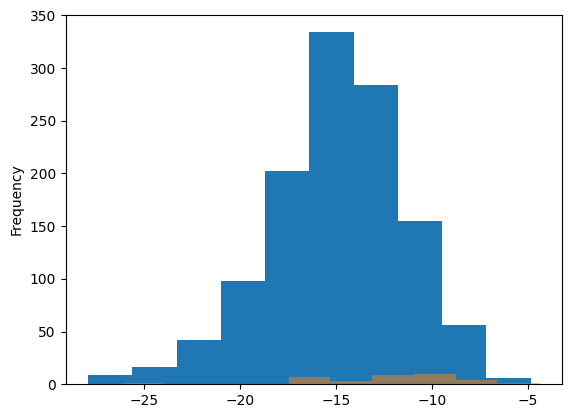

In [27]:
results[~results.in_gold].loc["d06"].semantic_score.plot.hist()
results[results.in_gold].loc["d06"].semantic_score.plot.hist(alpha=0.5)

<Axes: ylabel='Frequency'>

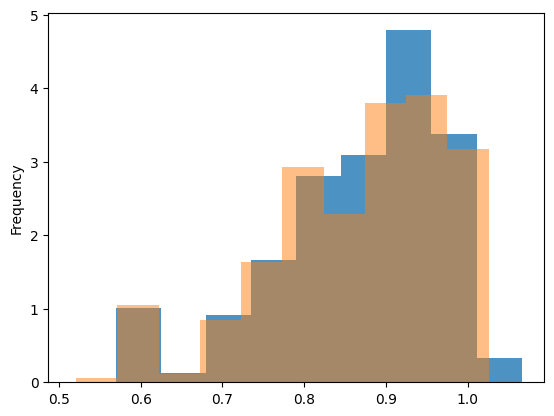

In [19]:
results[~results.in_gold].geary_c.plot.hist(density=True, alpha=0.8)
results[results.in_gold].geary_c.plot.hist(density=True, alpha=0.5)

<Axes: ylabel='Frequency'>

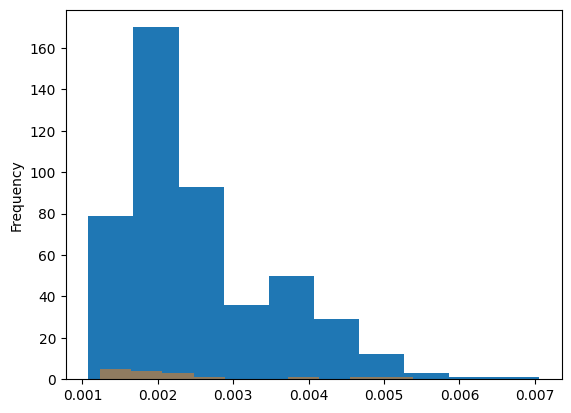

In [50]:
results[~results.in_gold].loc["d04"].moran_i.plot.hist()
results[results.in_gold].loc["d04"].moran_i.plot.hist(alpha=0.5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:35<00:00,  3.23s/it]


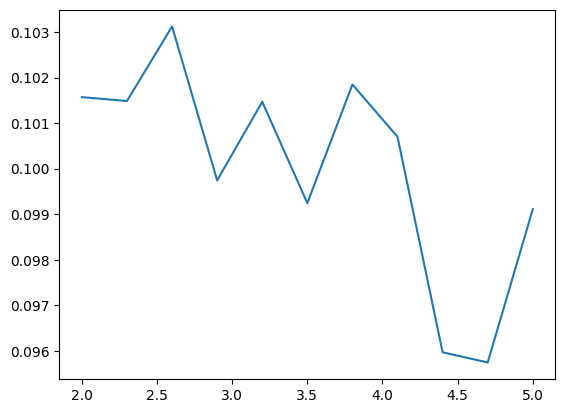

In [94]:
def rank(geo_association_results: pd.DataFrame, alpha=-0.5):
    """
    Compose final score and transform results to evaluation format

    Parameters
    ----------
    geo_association_results : pd.DataFrame
        _description_

    Returns
    -------
    dict:   {
                dataset_name: [
                    ( top_n_cand_and_scores: List[Tuple[str, float]] , candidates: List[str]),
                    ...
                    ],
                ...
            }
    """
    final_score = pd.DataFrame().reindex_like(geo_association_results)

    # best 0.35
    # final_score["score"] = (
    #    geo_association_results["semantic_score"]
    #    * geo_association_results["moran_i"]**(alpha)
    # )
    
    final_score["score"] = (
        geo_association_results["semantic_score"]
        * geo_association_results["geary_c"]**(alpha)
    )

    rankings = dict()
    for dataset in ["dataset"]:
        for topic in sorted(final_score.index.get_level_values(0).unique()):
            top_n_scores = sorted(
                list(final_score.loc[topic]["score"].items()),
                key=itemgetter(1),
                reverse=True,
            )
            candidates = final_score.loc[topic].index.to_list()
            rankings.setdefault(dataset, []).append((top_n_scores, candidates))

    return rankings

def test(results, true_labels, alpha):
    model_results = rank(results, alpha)

    model_results = postprocess_model_outputs(
                model_results, ranker.stemmer, None, [remove_new_lines_and_tabs, remove_whitespaces]
            )

    performance_metrics = evaluate_kp_extraction_base(model_results, true_labels)
    performance_metrics = pd.concat(
        [performance_metrics, evaluate_kp_extraction(model_results, true_labels)]
    )
    
    # display(
    #     performance_metrics[["Recall", "nDCG","F1_5", "F1_10", "F1_15"]].style.format('{:.2%}')
    # )
    
    return performance_metrics.loc["dataset_base_eval", "F1_15"]
    
import numpy as np
from tqdm import tqdm 
alphas = list(np.linspace(2, 5, 11))
f1_15 = []

for alpha in tqdm(alphas):
    # print(f"alpha = {alpha}")
    f1_15.append(test(results, true_labels, alpha))

plt.plot(alphas, f1_15)
plt.show()

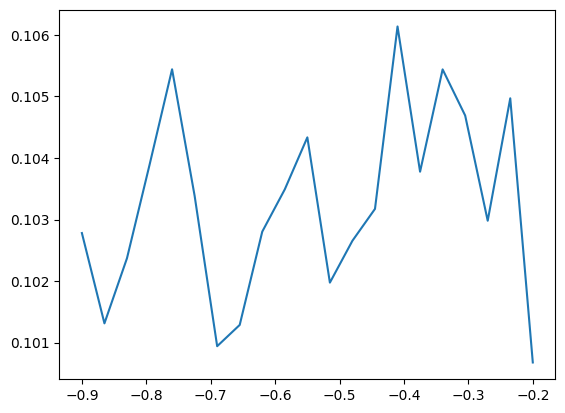